# MC based Cosmic Rate studies
This notebook does use the event/pfp/mcp trees, but no data

## Imports

In [111]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import time
import helpfunction as helper
%matplotlib inline

In [3]:
pd.options.display.max_columns=999

In [75]:
main_tree_name = 'cosmicstudies'

# Input files
file_name_mc_sce = './input/corsika_p_sce_30k.root'
file_name_mc_ddsce = './input/corsika_p_ddsce_8k.root'
file_name_mc_nosce = './input/corsika_p_nosce_6k.root'
file_name_mc_cmc = './input/corsika_cmc_sce_8k.root'

outdir = './Output/Paper/'

det_x = np.array([-1.55, 254.8])
det_y = np.array([-115.53, 117.47])
det_z = np.array([0.1, 1036.9])
eps= np.array([-0.001, 0.001])

muon_mass = 0.105658

good_start = -0.4e6          # Start of MC time where we are not biased by out of time charge
good_end = 0.4e6             # End of good MC time window (in ns)
t_begin = good_start/1e6
t_end = good_end/1e6

beam_window_start = 0.33
beam_window_end = 23.78

ub_tag = "MicroBooNE, In Progress"

In [5]:
mc_keys       = ['sce', 'ddsce', 'nosce', 'cmc']
mc_file_names = [file_name_mc_sce, file_name_mc_ddsce, file_name_mc_nosce, file_name_mc_cmc]
mc_files      = [uproot.open(f)[main_tree_name] for f in mc_file_names]
mc_labs       = ['CORSIKA, simulated space charge    ',
                 'CORSIKA, data-driven space charge  ',
                 'CORSIKA, without space charge      ',
                 'CORSIKA+CMC, simulated space charge']

## Functions

In [ ]:
# make apply function on mcp
# did it have a flash? if yes: save time diff and flashPE
# else: save timediff and flashPE of the closest following flash
# for every primary: was it generated during a flash? (8us)
# for every primary: was it generated during the veto? (0-23.8)
# causedFlash, duringFlash, timeDiff, flashPE
fl_diff_start = 0.05 
fl_diff_end = 0.35

def McpFlashMatcher(hash_id, time, df_flash):
    
    causedFlash, duringFlash = False, False
    timeDiff, flashPE = -1, 0
    
    flashes = df_flash.query('hash==@hash_id')
    time_diffs = np.array(flashes['flash_time'])-time/1000
    
    mask_delay = time_diffs>0
    
    if mask_delay.any(): #there is a delayed flash
        index = list(time_diffs).index(min(time_diffs[mask_delay]))
        timeDiff = time_diffs[index]
        flashPE = np.array(flashes['flash_totalPE'])[index]
        if fl_diff_start < timeDiff < fl_diff_end:
            causedFlash = True
    if ~causedFlash:
        if (~mask_delay).any():
            time_prev = max(time_diffs[~mask_delay])
            if time_prev > -8:
                duringFlash = True
                
    return (causedFlash, duringFlash,timeDiff, flashPE)

## Load the data

In [42]:
#['sce', 'ddsce', 'nosce', 'cmc']
mc_def = 1

In [43]:
n_events = mc_files[mc_def]['Event'].numentries

In [44]:
# Load mcp df
# Primary particles
df_mcp = mc_files[mc_def]['MCParticles'].pandas.df().query('mc_process==23')
df_muons = df_mcp.query('(mc_pdg_code==13 | mc_pdg_code==-13)')

In [45]:
df_mcp['mc_part_inside'].value_counts()

True     259971
False    121373
Name: mc_part_inside, dtype: int64

In [46]:
df_mc_muon_cross = df_muons.query('mc_part_inside')
df_mc_muon_cross['Kinetic Energy'] = df_mc_muon_cross['mc_energy']-muon_mass

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [47]:
# Time in seconds of the sample
total_time = (max(df_mcp['mc_time'])-min(df_mcp['mc_time']))*1e-9*n_events
print(total_time)
# Area in m*m
total_area = (det_x[1]-det_x[0])*(det_z[1]-det_z[0])/1e4
z_safe = det_z-eps
x_safe = det_x-eps

57.12952326


In [48]:
# amount of muons in the TPC:
len(df_mc_muon_cross)/total_time
loc_query = '(mc_startz_tpc>@z_safe[0]) & (mc_startz_tpc< @z_safe[1]) & \
             (mc_startx_tpc>@x_safe[0]) & (mc_startx_tpc< @x_safe[1])'

rate = len(df_mc_muon_cross.query(loc_query)["mc_startz_tpc"])/total_area/total_time
err = np.sqrt(rate*total_area*total_time)/total_area/total_time
print('Muon flux though TPC top: {0:.2f}+-{1:.2f} muons/(m*m*s)'.format(rate,err))
rate_tpc = len(df_mc_muon_cross)/total_time
err = np.sqrt(rate*total_time)/total_time
print('Muon flux in TPC: {0:.1f}+-{1:.1f} muons/s'.format(rate_tpc,err))

Muon flux though TPC top: 111.56+-0.27 muons/(m*m*s)
Muon flux in TPC: 4384.5+-1.4 muons/s


## Plots MC only

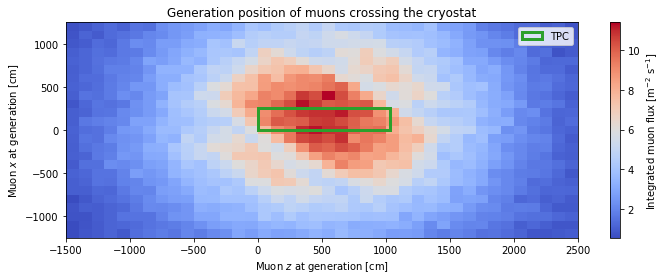

In [49]:
# Make a plot of the muon density at the generation!
# Area in m*m
this_area = (40)*(25)
weights = np.full((len(df_muons)), (25*40)/this_area/total_time)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
c = ax.hist2d(df_muons["mc_startz"],df_muons["mc_startx"], range=((-1500,2500),(-1250,1250)), 
              cmap='coolwarm', bins=(40,25), weights=weights)
clb = fig.colorbar(c[3], ax=ax)
clb.set_label(r'Integrated muon flux [m$^{-2}$ s$^{-1}$]')
rect = patches.Rectangle((det_z[0],det_x[0]),det_z[1]-det_z[0],det_x[1]-det_x[0],
                         linewidth=3,edgecolor='C2',facecolor='none', label='TPC')
ax.add_patch(rect)
ax.legend()
ax.set_ylabel(r'Muon $x$ at generation [cm]')
ax.set_xlabel(r'Muon $z$ at generation [cm]')
ax.set_title('Generation position of muons crossing the cryostat')

fig.tight_layout()
plt.savefig(outdir+"startxz_generation.pdf", bbox_inches="tight")

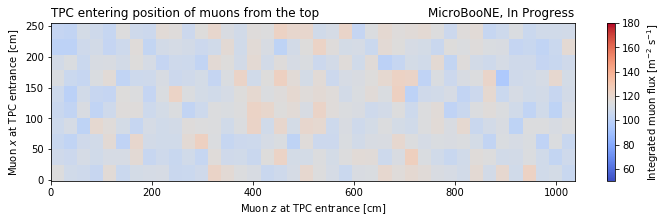

In [50]:
# Make a plot of the muon density at TPC entrance!
fig, ax = plt.subplots(1, 1, figsize=(10, 3.2))

np.full((2, 2), np.inf)

x_bin = 10
z_bin = 40
weights = np.full((len(df_mc_muon_cross["mc_startz_tpc"])), (x_bin*z_bin)/total_area/total_time)

c = ax.hist2d(df_mc_muon_cross["mc_startz_tpc"],df_mc_muon_cross["mc_startx_tpc"], 
              range=((z_safe[0], z_safe[1]), (x_safe[0], x_safe[1])), 
              cmap='coolwarm', bins=(z_bin,x_bin), weights=weights, vmin=50,vmax=180)

clb = fig.colorbar(c[3], ax=ax)
clb.set_label(r'Integrated muon flux [m$^{-2}$ s$^{-1}$]')

ax.set_ylabel(r'Muon $x$ at TPC entrance [cm]')
ax.set_xlabel(r'Muon $z$ at TPC entrance [cm]')
ax.set_title('TPC entering position of muons from the top', loc='left')
ax.set_title(ub_tag, loc='right')

fig.tight_layout()
plt.savefig(outdir+"startxz_crossing.pdf", bbox_inches="tight")

In [51]:
# What fraction of muons stop inside the TPC?
stopping_fraction = df_mc_muon_cross['mc_end_inside'].value_counts().values[1]/len(df_mc_muon_cross)
print('Fraction of stopping muons: {0:.2f}%'.format(stopping_fraction*100))

Fraction of stopping muons: 11.74%


/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


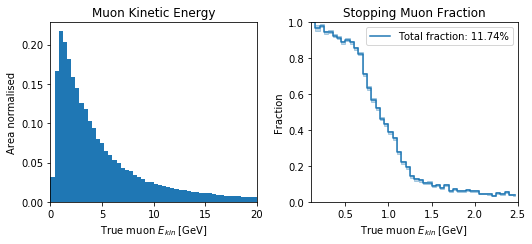

In [52]:
# make a plot of the muon kinetic energy and the fraction of stopping muons in function of that!
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.5))
N=50
edges = np.linspace(0,20,N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]

bins,_,_ = ax[0].hist(df_mc_muon_cross['Kinetic Energy'], bins=edges, density=1)
ax[0].set_xlim(0,20)
ax[0].set_xlabel(r'True muon $E_{kin}$ [GeV]')
ax[0].set_ylabel('Area normalised')
ax[0].set_title('Muon Kinetic Energy')

N=50
edges = np.linspace(0,2.5,N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]
denom,_ = np.histogram(df_mc_muon_cross['Kinetic Energy'], bins=edges)
nom,_ = np.histogram(df_mc_muon_cross.query('mc_end_inside')['Kinetic Energy'], bins=edges)
fraq = nom/denom

err = np.sqrt( fraq*(1-fraq)/denom )
ax[1].step(edges_mid, fraq, where='mid', label = r'Total fraction: {0:.2f}%'.format(stopping_fraction*100))
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C0')
ax[1].set_xlim(0.1,2.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'True muon $E_{kin}$ [GeV]')
ax[1].set_ylabel('Fraction')
ax[1].set_title('Stopping Muon Fraction')
ax[1].legend(loc='upper right')

fig.tight_layout()
plt.savefig(outdir+"mc_muon_E.pdf", bbox_inches="tight")

## Plots MC+TPC

In [53]:
# Load pfp df
mc_pfp = [f['PFParticles'].pandas.df() for f in mc_files]

In [58]:
primary_matched_query = '(track_matched_process==23)'
muon_matched_query = '(track_matched_pdgcode==13 | track_matched_pdgcode==-13)'
intpc_matched_query = '(track_matched_length_tpc>0)' 
matched_query = primary_matched_query+' & '+muon_matched_query+ ' & '+intpc_matched_query

df_pfp_matched_unique = mc_pfp[mc_def].drop_duplicates(subset=['track_matched_time', 'track_matched_energy'])
df_mc_muon_cross_matched = df_pfp_matched_unique.query(matched_query)

df_pfp_matched_unique25 = mc_pfp[mc_def].query("track_length>25").drop_duplicates(subset=['track_matched_time', 'track_matched_energy'])
df_mc_muon_cross_matched_25 = df_pfp_matched_unique25.query(matched_query)

In [59]:
#Fraction of muon track that are in the tpc for 25cm compared to 5cm
print(len(df_mc_muon_cross.query("mc_length_tpc>5"))/len(df_mc_muon_cross))
print(len(df_mc_muon_cross.query("mc_length_tpc>25"))/len(df_mc_muon_cross))

0.9862385321100917
0.9328135355035492


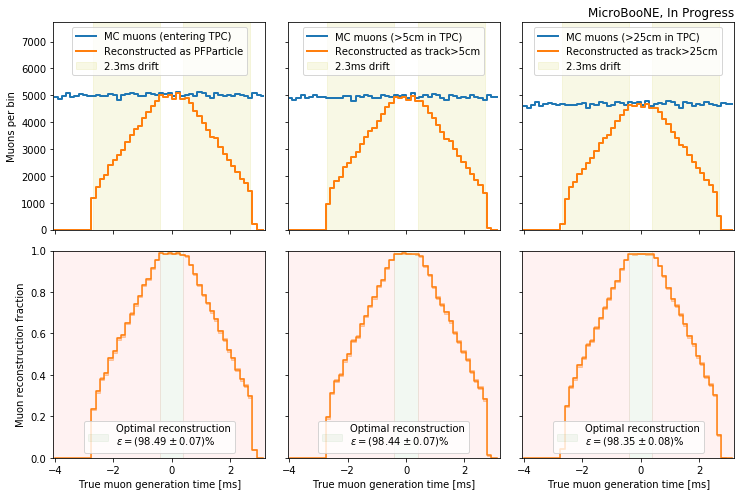

In [60]:
fig, ax = plt.subplots(ncols = 3, nrows=2, sharey='row', sharex=True, figsize=(10.5,7))
N=50
x_min=min(df_mc_muon_cross['mc_time']/1e6)
x_max=max(df_mc_muon_cross['mc_time']/1e6)

nom_labs  =['Reconstructed as PFParticle', 'Reconstructed as track>5cm', 'Reconstructed as track>25cm']
denom_arr   = [df_mc_muon_cross['mc_time']/1e6, 
             df_mc_muon_cross.query("mc_length_tpc>5")['mc_time']/1e6, 
             df_mc_muon_cross.query("mc_length_tpc>25")['mc_time']/1e6]

denom_labs = ['MC muons (entering TPC)', 'MC muons (>5cm in TPC)', 'MC muons (>25cm in TPC)']
nom_arr =[df_mc_muon_cross.query("mc_is_matched==1")['mc_time']/1e6, 
            df_mc_muon_cross_matched.query('track_matched_length_tpc>5')['track_matched_time']/1e6,
            df_mc_muon_cross_matched_25.query('track_matched_length_tpc>25')['track_matched_time']/1e6]

edges, edges_mid, nom_bins, nom_errs, max_y = helper.histHelper(N, x_min, x_max, nom_arr)
_, _, denom_bins, denom_errs, max_y = helper.histHelper(N, x_min, x_max, denom_arr)

iterable = enumerate(zip(nom_arr, nom_labs,nom_bins, nom_errs, denom_arr, denom_labs, denom_bins, denom_errs))
for i,(nom, nom_lab,nom_bin, nom_err, denom, denom_lab, denom_bin, denom_err) in iterable:
    # Upper row
    ax[0][i].step(edges_mid, denom_bin, lw=2, label=denom_lab, where='mid')
    ax[0][i].fill_between(edges_mid, denom_bin - denom_err, denom_bin - denom_err, alpha=0.3, step='mid') 
    ax[0][i].step(edges_mid, nom_bin, lw=2, label=nom_lab, where='mid')
    ax[0][i].fill_between(edges_mid, nom_bin - nom_err, nom_bin - nom_err, alpha=0.3, step='mid')
    ax[0][i].set_ylim(0,max(max_y)*1.5)
    ax[0][i].set_xlim(x_min,x_max)
    ax[0][i].axvspan(t_begin-2.3,t_begin, alpha=0.1, color="y", label='2.3ms drift')
    ax[0][i].axvspan(t_end,t_end+2.3, alpha=0.1, color="y")
    ax[0][i].legend(loc='upper center')
    
    # Lower row
    ratio = sum(nom.between(t_begin,t_end))/sum(denom.between(t_begin,t_end))
    ratio_err = np.sqrt((1-ratio)*ratio/sum(denom.between(t_begin,t_end)))
    fraq = nom_bin/denom_bin
    err = np.sqrt( fraq*(1-fraq)/denom_bin )
    ax[1][i].step(edges_mid, fraq, where='mid',color="C1")
    ax[1][i].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C1')
    ax[1][i].set_ylim(0,1)
    ax[1][i].axvspan(x_min,t_begin, alpha=0.05, color="red")
    ratio_str = r'$\varepsilon = ({0:.2f}\pm{1:.2f})\%$'.format(ratio*100,ratio_err*100)
    ax[1][i].axvspan(t_begin,t_end, alpha=0.05, color="green", label='Optimal reconstruction\n'+ratio_str)
    ax[1][i].axvspan(t_end,x_max, alpha=0.05, color="red")
    ax[1][i].set_xlabel(r'True muon generation time [ms]')
    ax[1][i].legend(loc='lower center')
    
ax[0][0].set_ylabel(r'Muons per bin')
ax[1][0].set_ylabel(r'Muon reconstruction fraction')
ax[0][2].set_title(ub_tag, loc='right')

fig.tight_layout()
fig.savefig(outdir+"match_eff.pdf", bbox_inches="tight")

## Plots MC+PMTS

In [64]:
df_flash = mc_files[mc_def]['SimpleCosmicFlashes'].pandas.df()

In [95]:
df_flash['hash'] = df_flash[['event', 'run', 'subrun', 'num_mcp']].apply(lambda x: hash(tuple(x)), axis = 1)
df_flash_basic = df_flash[['hash', 'flash_time', 'flash_totalPE']].copy()

In [141]:
df_mcp['hash'] = df_mcp[['event', 'run', 'subrun', 'num_mcp']].apply(lambda x: hash(tuple(x)), axis = 1)

cols = ['mc_energy', 'mc_pdg_code', 'mc_end_process', 'mc_start_inside', 'mc_end_inside', 'mc_part_inside',
        'mc_startx_tpc', 'mc_starty_tpc', 'mc_startz_tpc', 'mc_endx_tpc', 'mc_endy_tpc', 'mc_endz_tpc', 
        'mc_length_tpc', 'hash', 'mc_time']

df_mcp_flash = df_mcp[cols]
df_mcp_flash = df_mcp_flash[df_mcp_flash['mc_time'].between(-2450000,2350000)].copy()
df_mcp_flash['duringVeto'] = df_mcp_flash['mc_time'].between(0,23800)
df_mcp_flash['mc_avgy_tpc'] = (df_mcp_flash['mc_starty_tpc']+df_mcp_flash['mc_endy_tpc'])/2
df_mcp_flash['mc_avgz_tpc'] = (df_mcp_flash['mc_startz_tpc']+df_mcp_flash['mc_endz_tpc'])/2
df_mcp_flash['mc_avgx_tpc'] = (df_mcp_flash['mc_startx_tpc']+df_mcp_flash['mc_endx_tpc'])/2

Index(['mc_energy', 'mc_pdg_code', 'mc_end_process', 'mc_start_inside',
       'mc_end_inside', 'mc_part_inside', 'mc_startx_tpc', 'mc_starty_tpc',
       'mc_startz_tpc', 'mc_endx_tpc', 'mc_endy_tpc', 'mc_endz_tpc',
       'mc_length_tpc', 'hash', 'mc_time', 'duringVeto', 'mc_avgy_tpc',
       'mc_avgz_tpc', 'mc_avgx_tpc'],
      dtype='object')

In [143]:
n = 25243
df_mcp_flash_head= df_mcp_flash#.head(n).copy()

In [144]:
# Do the actual matching between mcp and flashes, takes approx 0.1s per event!
start = time.time()
cols = ['causedFlash', 'duringFlash','timeDiff', 'flashPE']
df_mcp_flash_head['causedFlash'], df_mcp_flash_head['duringFlash'], df_mcp_flash_head['timeDiff'], df_mcp_flash_head['flashPE'] = zip(*df_mcp_flash_head.apply(lambda x: McpFlashMatcher(x['hash'],x['mc_time'],df_flash_basic), axis=1))
done = time.time()
print(done - start)

705.2248513698578


### Flash purity

In [168]:
df_matched_flashes = df_mcp_flash_head.query('causedFlash').drop_duplicates(['hash','flashPE'])
df_matched_flashes_mu = df_mcp_flash_head.query('causedFlash & abs(mc_pdg_code)==13 & mc_part_inside').drop_duplicates(['hash','flashPE'])
df_matched_flashes_mu_out = df_mcp_flash_head.query('causedFlash & abs(mc_pdg_code)==13 & ~mc_part_inside').drop_duplicates(['hash','flashPE'])
df_matched_flashes_other = df_mcp_flash_head.query('causedFlash & abs(mc_pdg_code)!=13').drop_duplicates(['hash','flashPE'])

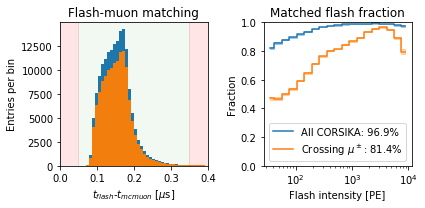

In [165]:
# make a plot of flash muon time difference and the flashmatch PE efficiency:

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
N=50
edges = np.linspace(0,0.4,N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]

bins,_,_ = ax[0].hist(df_mcp_flash_head['timeDiff'], bins=edges)
bins_mu,_,_ = ax[0].hist(df_mcp_flash_head.query('mc_part_inside & abs(mc_pdg_code)==13')['timeDiff'], bins=edges)

ax[0].set_xlabel(r'$t_{flash}$-$t_{mcmuon}$ [$\mu$s]')
ax[0].set_ylabel('Entries per bin')
ax[0].set_title('Flash-muon matching')
ax[0].axvspan(0,fl_diff_start, alpha=0.1, color="red")
ax[0].axvspan(fl_diff_start,fl_diff_end, alpha=0.05, color="green")
ax[0].axvspan(fl_diff_end,0.4, alpha=0.1, color="red")
ax[0].set_xlim(0,0.4)
#ax[0].set_ylim(0,1000)

N=19
edges=np.logspace(np.log10(30),np.log10(10000),N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]

# For all mcp
denom,_ = np.histogram(df_flash_basic['flash_totalPE'], bins=edges)
nom,_ = np.histogram(df_matched_flashes['flashPE'], bins=edges)
fraq = nom/denom
ratio = len(df_matched_flashes['flashPE'])/len(df_flash_basic['flash_totalPE'])
err = np.sqrt( fraq*(1-fraq)/denom )
ax[1].step(edges_mid, fraq, where='mid', label = r'All CORSIKA: {0:.1f}%'.format(ratio*100))
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C0')

# For crossing muons
denom,_ = np.histogram(df_flash_basic['flash_totalPE'], bins=edges)
nom,_ = np.histogram(df_matched_flashes_mu['flashPE'], bins=edges)
fraq = nom/denom
ratio = len(df_matched_flashes_mu['flashPE'])/len(df_flash_basic['flash_totalPE'])
err = np.sqrt( fraq*(1-fraq)/denom )
ax[1].step(edges_mid, fraq, where='mid', label = r'Crossing $\mu^\pm$: {0:.1f}%'.format(ratio*100))
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C1')

ax[1].set_ylim(0.,1.)
ax[1].set_xlabel(r'Flash intensity [PE]')
ax[1].set_ylabel('Fraction')
ax[1].set_title('Matched flash fraction')
ax[1].set_xscale("log", nonposx='clip')
ax[1].legend()

fig.tight_layout()
plt.savefig(outdir+"flash_muon_matching.pdf", bbox_inches="tight")

In [171]:
rate = len(df_matched_flashes_mu)/len(df_flash_basic)
err = helper.effErr(len(df_matched_flashes_mu), len(df_flash_basic))
print('Flashes by muons in TPC: {0:.2f}+-{1:.2f}%'.format(rate*100,err*100))
rate = len(df_matched_flashes_mu_out)/len(df_flash_basic)
err = helper.effErr(len(df_matched_flashes_mu_out), len(df_flash_basic))
print('Flashes by muons out TPC: {0:.2f}+-{1:.2f}%'.format(rate*100,err*100))
rate = len(df_matched_flashes_other)/len(df_flash_basic)
err = helper.effErr(len(df_matched_flashes_other), len(df_flash_basic))
print('Flashes by other types: {0:.2f}+-{1:.2f}%'.format(rate*100,err*100))

Flashes by muons in TPC: 81.43+-0.09%
Flashes by muons out TPC: 12.46+-0.08%
Flashes by other types: 3.22+-0.04%


### Flash efficiency

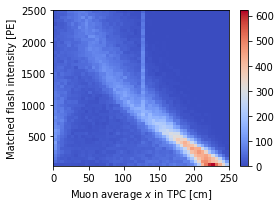

In [184]:
data_fl = df_matched_flashes_mu['flashPE']
data_mc_avgx = df_matched_flashes_mu['mc_avgx_tpc']

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

c = ax.hist2d(data_mc_avgx, data_fl, range=((0,250),(30,2500)), cmap='coolwarm', bins=(50,50))
plt.colorbar(c[3], ax=ax)
ax.set_xlabel('Muon average $x$ in TPC [cm]')
ax.set_ylabel('Matched flash intensity [PE]')
fig.tight_layout()
plt.savefig(outdir+"mux_flashPE.pdf", bbox_inches="tight")

In [192]:
avgx = {
    "name": 'mc_avgx_tpc',
    "bins": 50,
    "x_min": det_x[0],
    "x_max": det_x[1],
    "x_label": r'Average $x$ in TPC [cm]'
}

avgy = {
    "name": 'mc_avgy_tpc',
    "bins": 50,
    "x_min": det_y[0],
    "x_max": det_y[1],
    "x_label": r'Average $y$ in TPC [cm]',
    "ylog": 1
}

avgz = {
    "name": "mc_avgz_tpc",
    "bins": 50,
    "x_min": det_z[0],
    "x_max": det_z[1],
    "x_label": r'Average $z$ in TPC [cm]'
}

lengthtpc = {
    "name": "mc_length_tpc",
    "bins": 50,
    "x_min": 0,
    "x_max": 400,
    "x_label": 'Length inside the TPC [cm]',
}

energy = {
    "name": "mc_energy",
    "bins": 50,
    "x_min": 0.1,
    "x_max": 10,
    "x_label": 'Muon true energy [GeV]',
}

list_plot = [avgx, avgy, avgz, lengthtpc, energy]

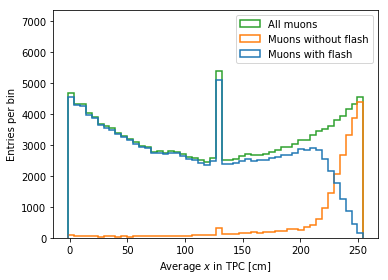

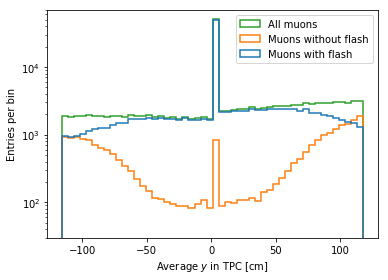

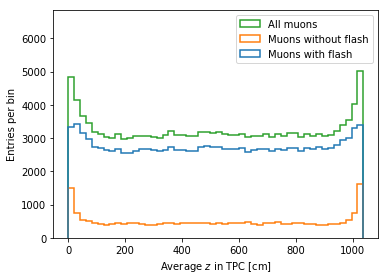

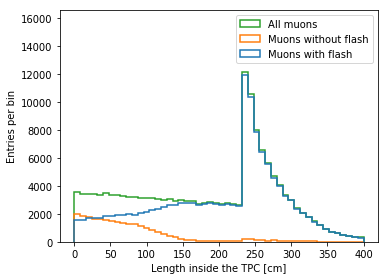

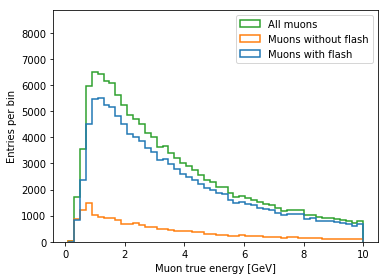

In [197]:
labs = ['Muons with flash', 'Muons without flash', 'All muons']

df_view = df_mcp_flash_head.query('abs(mc_pdg_code)==13 & mc_part_inside & ~duringVeto & ~duringFlash')

for s in list_plot:
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
    
    data = [df_view.query('causedFlash')[s['name']], 
            df_view.query('~causedFlash')[s['name']], 
            df_view[s['name']]]
    
    ax.hist(data,label=labs, histtype='step', lw=1.5, bins=s['bins'], range=(s['x_min'],s['x_max']))
    ax.set_xlabel(s['x_label'])
    ax.set_ylabel('Entries per bin')
    ax.legend(loc=0)
    ax.set_ylim(0,1.3*ax.get_ylim()[1])
    
    if 'ylog' in s:
        ax.set_yscale('log')
        ax.set_ylim(30,ax.get_ylim()[1])

    fig.tight_layout()
    plt.savefig(outdir+"flash_muon_match_"+s['name']+".pdf", bbox_inches="tight")

In [209]:
# What fraction of in TPC muons creates a flash:
q_str = 'abs(mc_pdg_code)==13 & mc_part_inside & ~duringVeto & ~duringFlash'

rate = sum(df_mcp_flash_head.query(q_str)['causedFlash'])/len(df_mcp_flash_head.query(q_str))
err = helper.effErr(sum(df_mcp_flash_head.query(q_str)['causedFlash']), len(df_mcp_flash_head.query(q_str)))
print('In TPC muons causing a flash: {0:.2f}+-{1:.2f}%'.format(rate*100,err*100))

In TPC muons causing a flash: 84.84+-0.09%


In [206]:
# Create a golden sample in which all muons have a flash matched to them 97%:
q_str = 'abs(mc_pdg_code)==13 & mc_part_inside & ~duringVeto & ~duringFlash & \
         (mc_avgx_tpc < 205) & (mc_avgz_tpc > 50) & (mc_avgz_tpc < 990)'# & \
         #(mc_energy>1) & (mc_length_tpc>50)'

df_mcp_flash_head.query(q_str)['causedFlash'].value_counts()/len(df_mcp_flash_head.query(q_str))

True     0.970943
False    0.029057
Name: causedFlash, dtype: float64

In [207]:
# Are there still things I want to do? flashes that are not matched, 
# are they close after matched flashes?